# Level 2 挑選一段功能執行並寫上註解

# 挑選功能: 利用爬蟲後所得的資料繪製出文字雲

In [2]:
import os
import pickle
import jieba
import operator
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from datetime import datetime
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from modules import *

font_path = '../tools/msjh.ttc'
font = font_manager.FontProperties(fname='../tools/msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)

### 載入新聞資料

In [3]:
#開啟爬蟲好的新聞資料
with open('../crawler/data/new_talk.pkl', 'rb') as f: 
    data = pickle.load(f)
#將資料倒序    
data = data[::-1]
#data裡每一筆資料皆含有date, title, link, content
#此環節我們只需要用到content，故利用迴圈將每一筆資料的content存入另一個list中，命名為contents
contents = [news['content'] for news in data]

### 使用 coshow 找出新詞 -> 自定義辭典
### 使用coshow的話會用到三個function，為方便說明故列於下方

In [4]:

def remove_punctuation(content_string, user_pc=False):
    """
    輸入的content_string中，如有出現!@#$%^&*()_+=-[]`~'\"|/\\abcdef...等皆以空格代替
    例如:
    >> content_string = "你好!我是"
    >> remove_punctuation(content_string)
    output: 你好 我是
    """
    if(user_pc):
        punctuation = user_pc
    else:
        punctuation=list("!@#$%^&*()_+=-[]`~'\"|/\\abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.;{}\r\xa0\u3000、，。「」！？；：<>")
        
    for p in punctuation:
        content_string = content_string.replace(p, " ")
    return(content_string)

def sort_dict_by_values(d):
    """
    將字典中的詞彙以value的大小做降序排序
    """
    return(sorted(d.items(), key=lambda x: x[1], reverse=True))

def get_coshow(contents):
    """
    將詞語存入dictionary，並計算其出現次數(存入value)
    舉例output(以出現次數由大到小排列):
     ('68', 1001),
     ('民進黨', 617),
     ('對於', 475),
     ('蔡英文', 471),
     ('柯文哲', 442),
     ('台北市長', 356),
     ('長參選人', 316),
     ('沒有', 288),
     ('今（', 261),
     ('）日', 258)]
    """
    coshow_dict = {}
    cat_content = ' '.join(contents) #將contents用空格連接起來
    clean_content = remove_punctuation(cat_content) #清除不必要的符號
    cut_content = jieba.lcut(clean_content) #預設模式分出詞彙並存回list
    cut_content = list(filter(lambda x: x!=' ', cut_content)) #選取列表中不是' '的字
    for i in range(len(cut_content)-1): #將字詞加入dictionary並計算每字詞出現次數存入value
        wcw = cut_content[i] + cut_content[i+1]
    #     print(wcw)
        try:
            coshow_dict[wcw] = coshow_dict[wcw] + 1
        except:
            coshow_dict[wcw] = 1

    sdbv = sort_dict_by_values(coshow_dict)
    return sdbv

get_coshow(contents[:1000])[:10]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\smile\AppData\Local\Temp\jieba.cache
Loading model cost 1.626 seconds.
Prefix dict has been built succesfully.


[('68', 1001),
 ('民進黨', 617),
 ('對於', 475),
 ('蔡英文', 471),
 ('柯文哲', 442),
 ('台北市長', 356),
 ('長參選人', 316),
 ('沒有', 288),
 ('今（', 261),
 ('）日', 258)]

### 設定繁體中文斷詞、載入自訂辭典、stopwords

In [5]:
jieba.set_dictionary('../jieba_data/dict.txt.big') #jieba預設詞庫 
jieba.load_userdict('../jieba_data/userdict.txt') #使用者定義詞庫
stopwords = [] #停止詞詞庫(一些冗字)
#建立停止詞詞庫
with open('../jieba_data/stopwords.txt', 'r', encoding='UTF-8') as file:
    for each in file.readlines(): #依次讀取每行
        stopwords.append(each.strip()) #去掉每行頭尾空白，加入stopwords列表
    stopwords.append(' ')

Building prefix dict from C:\Users\smile\Documents\GitHub\Political-News-Analysis\jieba_data\dict.txt.big ...
Dumping model to file cache C:\Users\smile\AppData\Local\Temp\jieba.u53374e2250144ea5c4753748f623d3c6.cache
Loading model cost 3.294 seconds.
Prefix dict has been built succesfully.


In [6]:
def lcut_to_dict(lcut):
    """
    建立字典(key = 某字詞 ; value = 此字詞出現次數)
    return時同時只保留不屬於stopwords的字詞
    """
    word_dict = dict(Counter(lcut)) #count the frequency 
#     word_dict.pop(' ')
    return(remove_stopwords_from_dict(word_dict, stopwords))

def remove_stopwords_from_dict(word_dict, stopwords):
    """
    去除word_dict裡屬於stopwords的字詞
    舉例:
    >> stopwords = ['python','Google']
    >> word_dict = {'python': 1,'Google': 2,'excel': 3}
    >> remove_stopwords_from_dict(word_dict, stopwords)
    output: {'excel': 3}
    """
    for w in stopwords:
        word_dict.pop(w, word_dict)
    return word_dict

# add cutted dict to each news
for i in range(len(data)):
    current_content = data[i]['content'] #取出content
    current_cutted = jieba.lcut(remove_punctuation(current_content)) #移除不必要符號，利用jieba切割字詞
    data[i]['cutted_dict'] = lcut_to_dict(current_cutted) #移除屬於stopwords的詞彙，存入cutted_dict中
    

In [7]:
get_coshow(contents[:1000])[:10]

[('68', 1001),
 ('今（', 390),
 ('）日', 327),
 ('他的', 254),
 ('為了', 252),
 ('都是', 250),
 ('也是', 216),
 ('台灣的', 203),
 ('的人', 196),
 ('的是', 187)]

In [8]:
def get_cutted_dict(list_of_news):
    """
    將新聞內容分開成字詞，建立字典
    """
    cat = ' '.join(list_of_news) #以空格連結
    cat = remove_punctuation(cat) #去除不必要符號
    cutted = jieba.lcut(cat) #利用jieba切割字詞
    return lcut_to_dict(cutted) #建立字典，去除停止詞

def first_n_words(cutted_dict, n, word_len=2, to=1000):
    """
    return前n高頻率的詞彙
    """
    sdbv = sort_dict_by_values(cutted_dict) #以value的值由大排到小
    return list(filter(lambda x: len(x[0])>=word_len and len(x[0])<=to, sdbv))[:n] #顯示前n個符合條件的詞語(字數介於2~1000之間) 

#先測試幾個
cutted_dict = get_cutted_dict(contents[:1000])
high_freq_pair = first_n_words(cutted_dict, 20) #顯示前20高頻率的字詞
high_freq_pair

[('台灣', 1380),
 ('國民黨', 783),
 ('侯友宜', 716),
 ('柯文哲', 691),
 ('民進黨', 681),
 ('指出', 600),
 ('中國', 561),
 ('媒體', 541),
 ('選舉', 521),
 ('市府', 501),
 ('希望', 494),
 ('公司', 487),
 ('一個', 469),
 ('美國', 464),
 ('政府', 448),
 ('未來', 413),
 ('提供', 412),
 ('蘇貞昌', 388),
 ('針對', 349),
 ('國家', 337)]

### 正式開始切割news裡的詞彙，存入字典cutted_dict中

In [10]:
#找出新聞中的詞彙及其出現頻率(去除不必要冗字)
cutted_dict = get_cutted_dict(contents)

### 在自己建立的字典中(從news得到的)，找出可能的人名及事件

In [11]:
# 可能人名(字數限定3個字，找1000個詞彙)
possible_name = first_n_words(cutted_dict, 1000, 3, 3)
possible_name[:10]

[('民進黨', 8922),
 ('國民黨', 8420),
 ('柯文哲', 8153),
 ('韓國瑜', 6590),
 ('陳其邁', 4683),
 ('蔡英文', 3738),
 ('蘇貞昌', 3280),
 ('姚文智', 2973),
 ('候選人', 2946),
 ('侯友宜', 2665)]

In [12]:
# 可能事件(字數限定4~1000個字，找200個詞彙)
possible_events = first_n_words(cutted_dict, 200, 4)
possible_events[:10]

[('台北市長柯文哲', 1590),
 ('總統蔡英文', 1356),
 ('時代力量', 1135),
 ('九二共識', 1022),
 ('行政院長賴清德', 1003),
 ('中華民國', 852),
 ('競選總部', 779),
 ('蔡英文總統', 762),
 ('競選辦公室', 720),
 ('兩岸關係', 708)]

### 載入人名、事件(事先寫好的)

In [13]:
names = []
with open('../data/names.txt', 'r', encoding='utf-8-sig') as f:
    names = f.read().split('\n')
    
events = []
with open('../data/events.txt', 'r', encoding='utf-8-sig') as f:
    events = f.read().split('\n')

In [14]:
#print幾個出來看看有沒有錯誤
print(' '.join(names[:5]))
print(' '.join(events[:5]))

柯文哲 韓國瑜 陳其邁 蔡英文 蘇貞昌
九二共識 兩岸關係 轉型正義 立委補選 九合一選舉


### 文字雲

In [15]:
def news_containing_keyword(keyword, news_list):
    """
    選取新聞內容中有出現關鍵字(keyword)的所有list
    """
    return list(filter(lambda news: keyword in news, news_list))

def get_wordcloud_of_keywords(keywords, list_of_news, image_path=False):
    """
    利用新聞找出與keywords相關的字詞，並用這些字詞畫出文字雲
    """
    if type(keywords) == str:
        keywords = [keywords]
    
    if image_path:
        coloring = np.array(Image.open(os.path.join(image_path)))
        color_func = ImageColorGenerator(coloring) #Color generator based on a color image.
        wc = WordCloud(max_font_size=30, #設定顏色、字的大小、圖的長寬等等
                       background_color="white",
                       mask=coloring,
                       color_func=color_func,
                       font_path=font_path,
                       width=1000, height=1000,
                      max_words=10000)
    else: #如果沒有照片
        wc = WordCloud(max_font_size=30,
                       background_color="white",
                       colormap='Set2', #利用預設模式畫圖
                       font_path=font_path,
                       width=1000, height=300,
                      max_words=1000)
    
    keyword_news = news_containing_keywords(keywords, list_of_news) #找出新聞內容中包含keywords的部分
    keyword_dict = get_cutted_dict(keyword_news) #在這些內容中找出特定詞彙及其出現頻率(去除不必要冗字)
    print(len(keyword_dict))
    im = wc.generate_from_frequencies(keyword_dict) #利用這些字詞的出現頻率畫出文字雲
    return im

47782


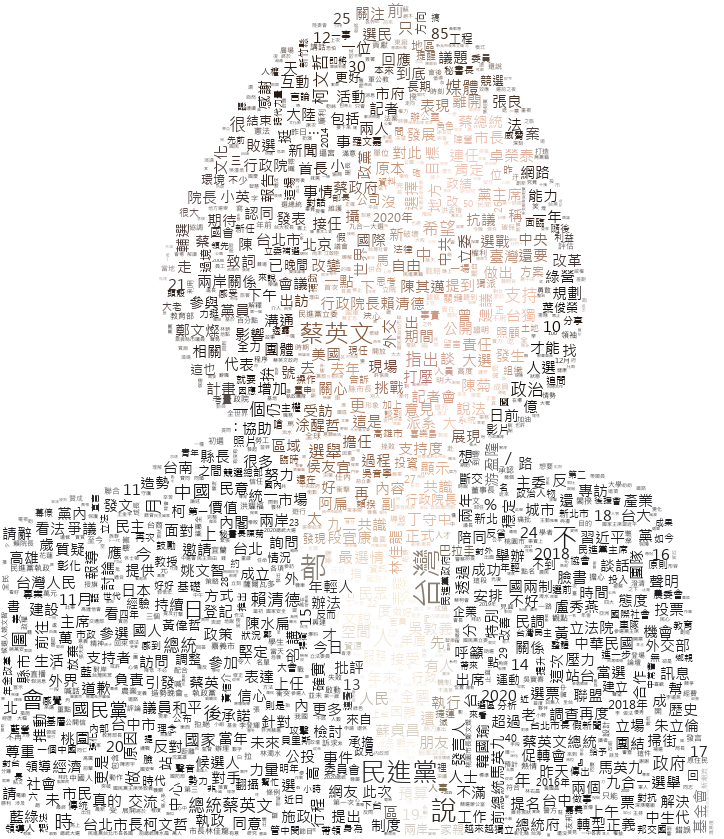

In [16]:
# 蔡英文
ten_wc = get_wordcloud_of_keywords('蔡英文', contents, '../politicians/ten.png')
# ten_wc.to_file('politicians/tenwc.png')
ten_wc.to_image()

In [17]:
#顯示前五個與蔡英文最為相關的字詞
news_containing_ten = news_containing_keyword('蔡英文', contents)
ten_dict = get_cutted_dict(news_containing_ten)
first_n_words(ten_dict, 5)

[('台灣', 5039), ('民進黨', 3893), ('蔡英文', 3738), ('中國', 2136), ('國民黨', 2021)]

47782


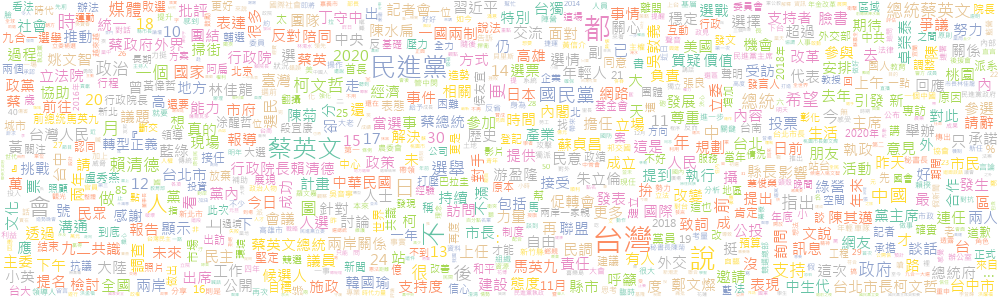

In [18]:
#在沒有給定照片下，畫出的文字雲
test_wc = get_wordcloud_of_keywords('蔡英文', contents)
test_wc.to_image()